In [1]:
%run ../utils.py
import numpy as np
import matplotlib.pyplot as plt
import os.path
import os.path as osp
from codex import io as codex_io
from codex import config as codex_config
from skimage import exposure

init_session()

Using TensorFlow backend.


In [174]:
# exp_name = '7-7-17-multicycle'
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle-out-none', '1-Processor')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 2
# mem_ch = 1
# best_z = 4
# crop = [slice(0, 512), slice(0, 512)]
# tile_file = 'reg001_X01_Y01.tif'

# exp_name = '20180607_D21_activated_Tcells'
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v01', 'processor', 'tile')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 0
# mem_ch = 2
# best_z = 14
# crop = [slice(None, None), slice(None, None)]
# tile_file = 'R001_X001_Y001.tif'

exp_name = '20180614_D22_RepA_Tcell_CD4-CD8-DAPI_5by5'
exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v01', 'processor', 'tile')
nuc_cyc = 0
nuc_ch = 0
best_z = 19
crop = [slice(None, None), slice(None, None)]
tile_file = 'R001_X002_Y002.tif'

exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)

In [175]:
exp_conf = codex_config.load(exp_conf_dir)
tile = codex_io.read_tile(osp.join(exp_data_dir, tile_file), exp_conf)
tile = tile[:, :, :, crop[0], crop[1]]

if tile.dtype == np.uint16:
    tile = exposure.rescale_intensity(tile, in_range=np.uint16, out_range=np.uint8).astype(np.uint8)

tile.shape, tile.dtype

((1, 25, 3, 1008, 1344), dtype('uint8'))

In [176]:
img_nuc = tile[nuc_cyc, best_z, nuc_ch]
img_nuc.shape

(1008, 1344)

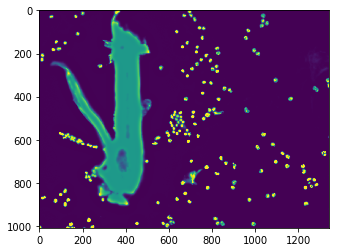

In [177]:
plt.imshow(img_nuc)

In [138]:
import imp
imp.reload(cytometer)

<module 'codex.cytometry.cytometer' from '/lab/repos/codex/python/pipeline/codex/cytometry/cytometer.py'>

In [168]:
%%time
from codex.cytometry import cytometer
cytom = cytometer.Cytometer2D(img_nuc.shape + (1,)).initialize()

CPU times: user 4.64 s, sys: 203 ms, total: 4.84 s
Wall time: 4.77 s


In [178]:
%%time
img_seg, img_pred, img_bin = cytom.segment(img_nuc, return_masks=True)

CPU times: user 482 ms, sys: 171 ms, total: 654 ms
Wall time: 605 ms


In [179]:
img_seg.shape, img_pred.shape, img_bin.shape

((1, 2, 1008, 1344), (1, 1008, 1344, 3), (1, 3, 1008, 1344))

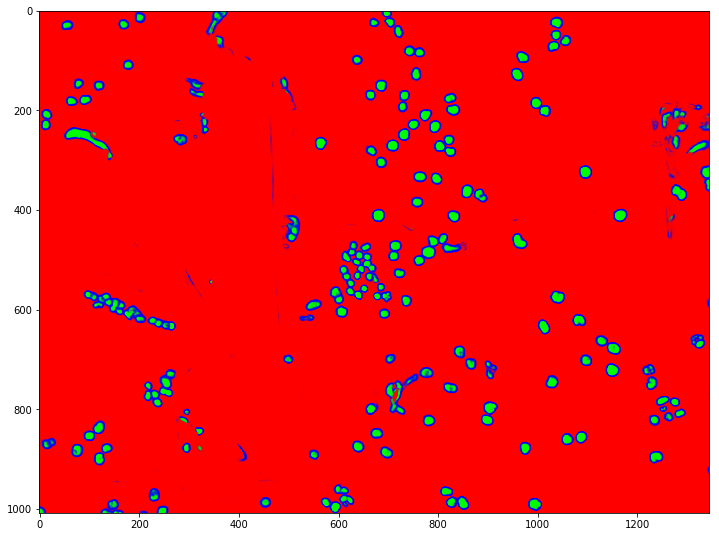

In [180]:
plt.imshow(img_pred[0])
plt.gcf().set_size_inches(12, 12)

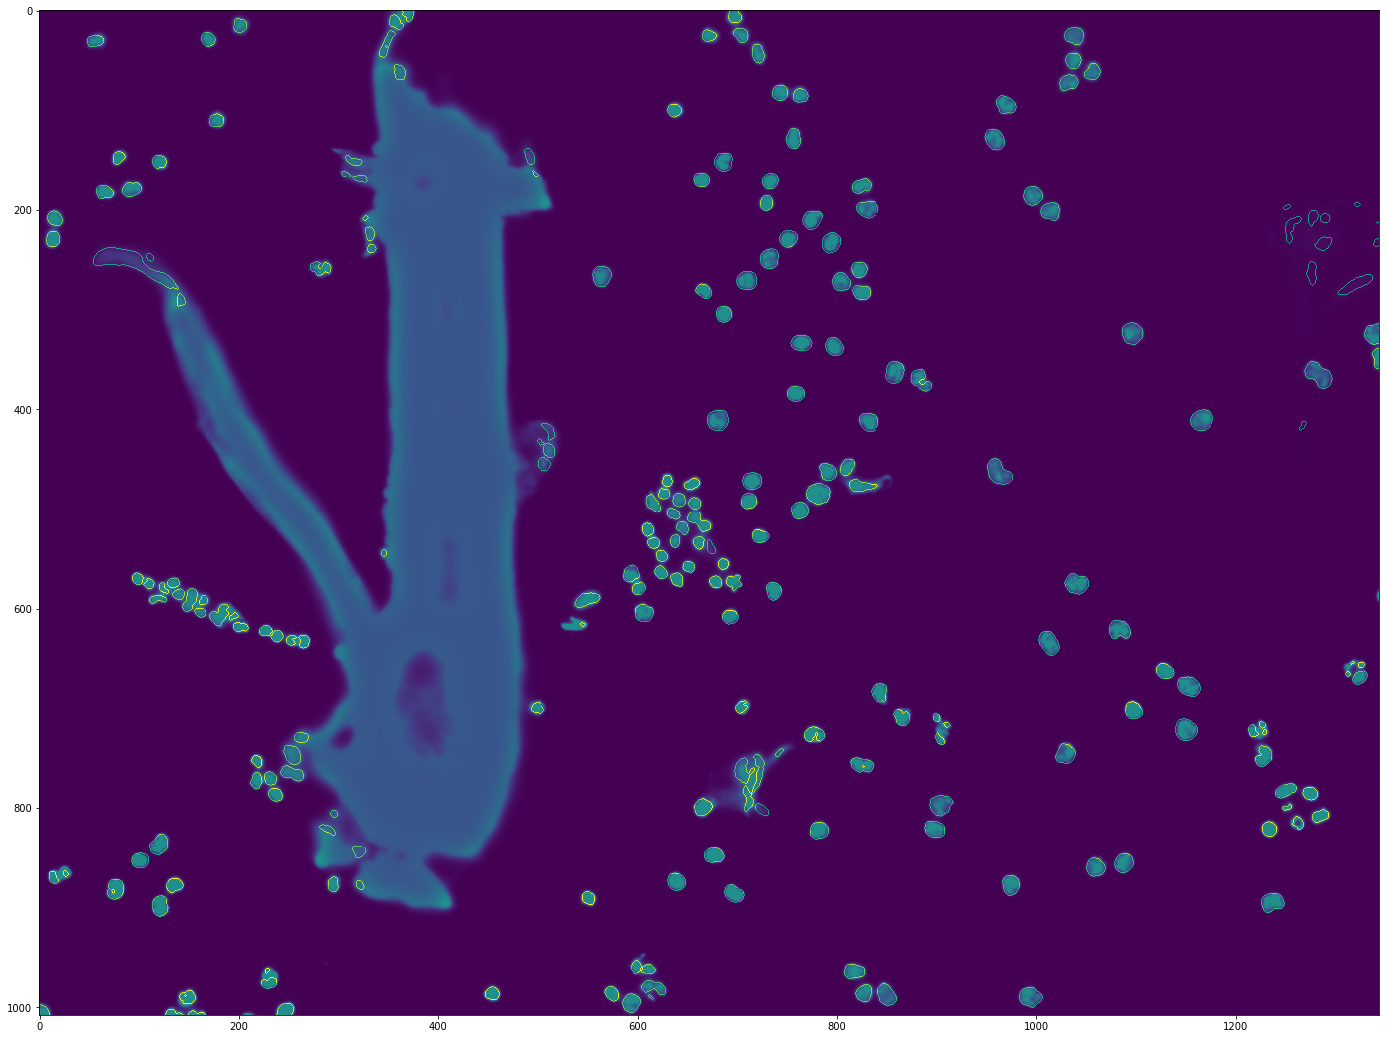

In [181]:
from skimage import segmentation
img_bound = segmentation.find_boundaries(img_seg[0, 1], mode='inner', background=0)
plt.imshow(.5*img_bound.astype(np.uint8) * 255 + .5*img_nuc)
plt.gcf().set_size_inches(24, 24)

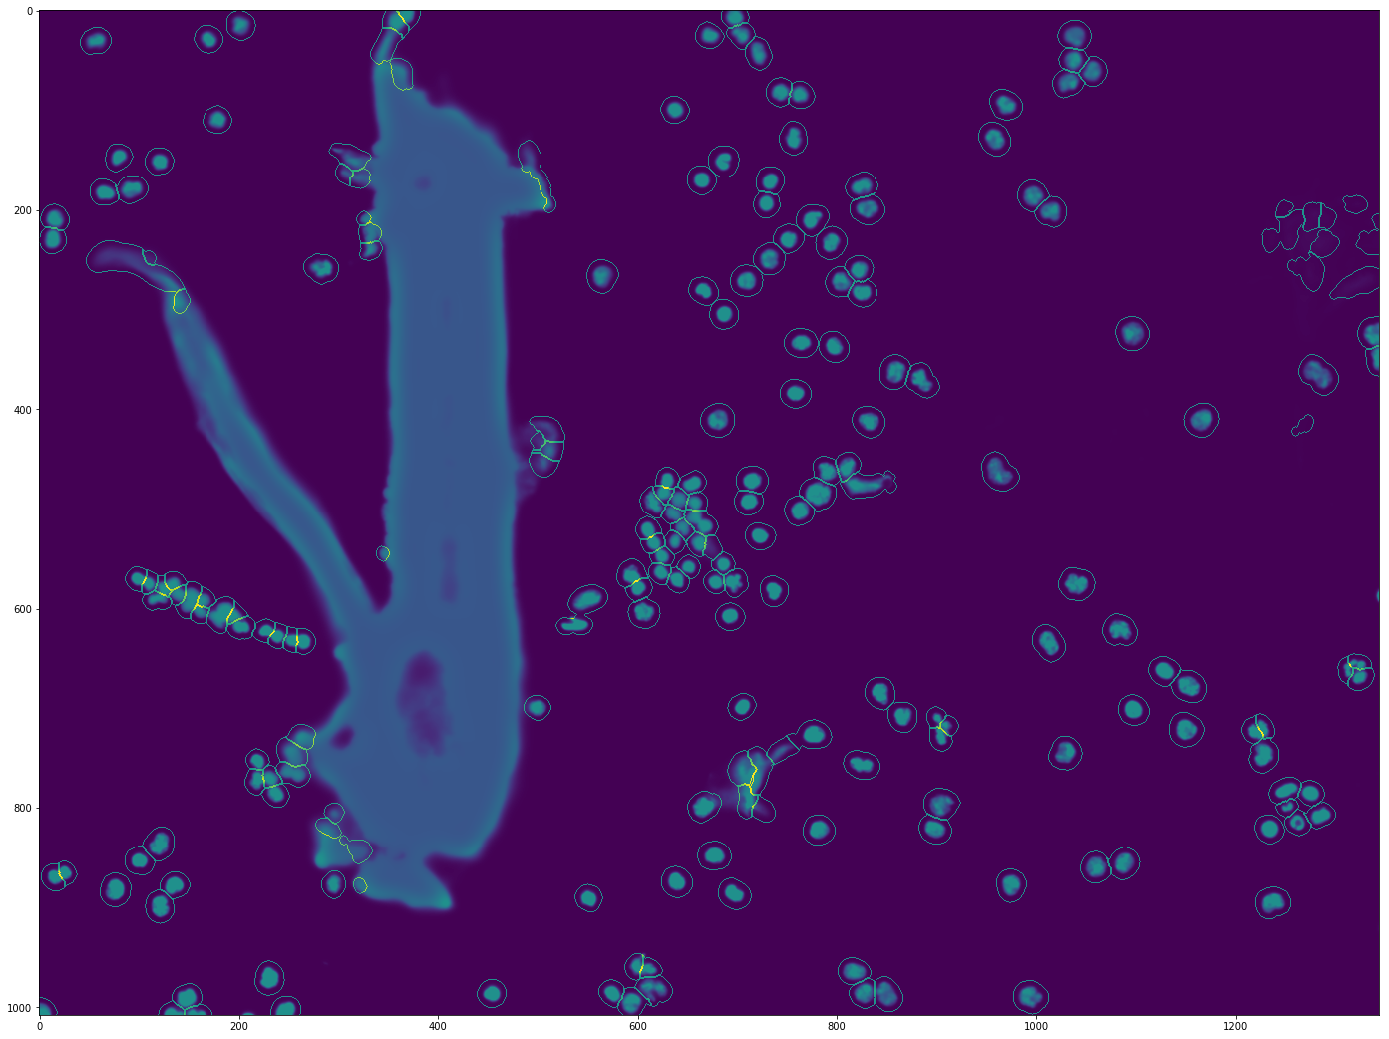

In [182]:
from skimage import segmentation
img_bound = segmentation.find_boundaries(img_seg[0, 0], mode='inner', background=0)
plt.imshow(.5*img_bound.astype(np.uint8) * 255 + .5*img_nuc)
plt.gcf().set_size_inches(24, 24)